In [2]:

import sys
sys.path.append('/Users/bence/code/liouvillian_metro/')

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from scipy.linalg import expm
import pickle
from copy import deepcopy
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace, state_fidelity
import time

from oft import oft
from tools.classical import find_ideal_heisenberg, trotter_step_heisenberg_qt, ham_evol_qt, hamiltonian_matrix

np.random.seed(667)

In [3]:
coeffs = [1.1, 0.8, 0.2, 1]
X = qt.sigmax()
Y = qt.sigmay()
Z = qt.sigmaz()

constr_times = []
diag_times = []
for n in range(4, 13, 1):
    print(f'Number of qubits: {n}')

    t0 = time.time()
    hamiltonian_qt = hamiltonian_matrix([X, X], [Y, Y], [Z, Z], coeffs=coeffs, num_qubits=n, symbreak_term=[Z])
    t1 = time.time()
    eigenenergies, eigenstates = np.linalg.eigh(hamiltonian_qt)
    t2 = time.time()
    diag_times.append(t2 - t1)
    constr_times.append(t1 - t0)
    print(f'Construction time: {t1 - t0}')
    print(f'Diagonalization time: {t2 - t1}')


Number of qubits: 4
Construction time: 0.003715991973876953
Diagonalization time: 0.00034618377685546875
Number of qubits: 5
Construction time: 0.0028722286224365234
Diagonalization time: 0.0002949237823486328
Number of qubits: 6
Construction time: 0.0033462047576904297
Diagonalization time: 0.002092123031616211
Number of qubits: 7
Construction time: 0.009341955184936523
Diagonalization time: 0.021015167236328125
Number of qubits: 8
Construction time: 0.007850885391235352
Diagonalization time: 0.10253405570983887
Number of qubits: 9
Construction time: 0.01694011688232422
Diagonalization time: 0.1712629795074463
Number of qubits: 10
Construction time: 0.067626953125
Diagonalization time: 0.9517068862915039
Number of qubits: 11
Construction time: 0.31467390060424805
Diagonalization time: 7.284855127334595
Number of qubits: 12
Construction time: 1.5288047790527344
Diagonalization time: 42.197052240371704


Text(0, 0.5, 'Time (s)')

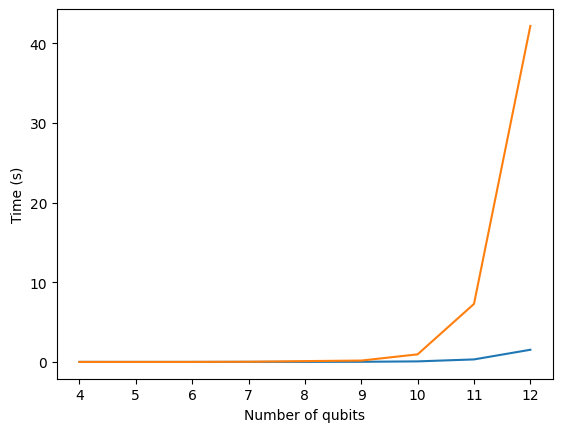

In [5]:
#plot the results
plt.figure()
plt.plot(range(4, 13, 1), constr_times, label='Construction time')
plt.plot(range(4, 13, 1), diag_times, label='Diagonalization time')
plt.xlabel('Number of qubits')
plt.ylabel('Time (s)')


In [8]:
# Extrapolate to 20 qubits
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * x**b

popt, pcov = curve_fit(func, range(4, 13, 1), diag_times)
print(popt)
x = np.linspace(4, 20, 100)
y = func(x, *popt)
plt.plot(x, y, label='Extrapolation')


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [50]:
num_qubits = 10
num_energy_bits = 11
delta = 0.01
eps = 0.1
sigma = 5
bohr_bound = 2 ** (-num_energy_bits + 1)
beta = 1
eig_index = 2
mix_time = 10

hamiltonian = find_ideal_heisenberg(num_qubits, bohr_bound, eps, signed=False, for_oft=True)

initial_state = hamiltonian.eigenstates[:, eig_index]
initial_dm = DensityMatrix(initial_state).data

/Users/bence/code/liouvillian_metro/tools/classical.py:222: SyntaxWarning: invalid escape sequence '\o'
  """Get the smallest Bohr frequency $\omega_0$ for a given Hamiltonian.


KeyboardInterrupt: 

In [40]:
# Create Gibbs state from eigenstates and eigenenergies
gibbs = expm(-beta * hamiltonian.qt.full()) / np.trace(expm(-beta * hamiltonian.qt.full()))
print(gibbs.shape)

(8, 8)


In [41]:
# Liouvillian, could be from (1.8), i.e. integral over the energies

N = 2**num_energy_bits
N_labels = np.arange(N / 2, dtype=int)
N_labels_neg = np.arange(- N / 2, 0, dtype=int)
N_labels = np.concatenate((N_labels, N_labels_neg))
energy_labels = 2 * np.pi * N_labels / N 
time_labels = N_labels

# rand_jump_index = np.random.randint(0, num_qubits)
site_list = [qt.qeye(2), qt.qeye(2), qt.qeye(2)]
x_jump_ops = []
for q in range(num_qubits):
    site_list[q] = qt.sigmax()
    x_jump_ops.append(qt.tensor(site_list).full())

### With Qutip MESOLVE

In [42]:
def trdist_to_gibbs(t, state):
    gibbs = qt.Qobj(expm(-beta * hamiltonian.qt.full()) / np.trace(expm(-beta * hamiltonian.qt.full())))
    trdist = qt.tracedist(state, gibbs)
    # print(f'Trace distance to Gibbs at time {t} is {trdist}')
    return trdist

def fid_with_gibbs(t, state):
    gibbs = qt.Qobj(expm(-beta * hamiltonian.qt.full()) / np.trace(expm(-beta * hamiltonian.qt.full())))
    fid = qt.fidelity(state, gibbs)
    # print(f'Fidelity with Gibbs at time {t} is {fid}')
    return fid

all_oft_jump_ops = []
for i in range(len(x_jump_ops)):
    jump_op = x_jump_ops[i]
    for phase in N_labels:
        energy = 2 * np.pi * phase / 2**num_energy_bits
        oft_op = oft(jump_op, phase, 2**num_energy_bits, sigma, hamiltonian=hamiltonian.qt.full())
        all_oft_jump_ops.append(qt.Qobj(oft_op))

no_H = qt.qeye(2**num_qubits)
times = np.linspace(0.0, mix_time, 10)
result_qt = qt.mesolve(no_H, qt.Qobj(initial_dm), times, all_oft_jump_ops, 
                       e_ops=[trdist_to_gibbs, fid_with_gibbs], options=qt.Options(store_states=True))


In [43]:
print(f'Last trace distance to Gibbs is {result_qt.expect[0][-1]}')
print(f'Last fid value is {result_qt.expect[1][-1]}')

Last trace distance to Gibbs is (0.08095893142529378+0j)
Last fid value is (0.9964337132962702+0j)


<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/var/folders/pg/6vn02n251m14stcv7vg03pjr0000gn/T/ipykernel_57383/381797867.py:2: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$e^{\mathcal{L}t}$, with $A = \{\sigma_i^x\}$')
/var/folders/pg/6vn02n251m14stcv7vg03pjr0000gn/T/ipykernel_57383/381797867.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(("$D(\\rho, \sigma)$", "$F(\\rho, \sigma)$"))
/var/folders/pg/6vn02n251m14stcv7vg03pjr0000gn/T/ipykernel_57383/381797867.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(("$D(\\rho, \sigma)$", "$F(\\rho, \sigma)$"))


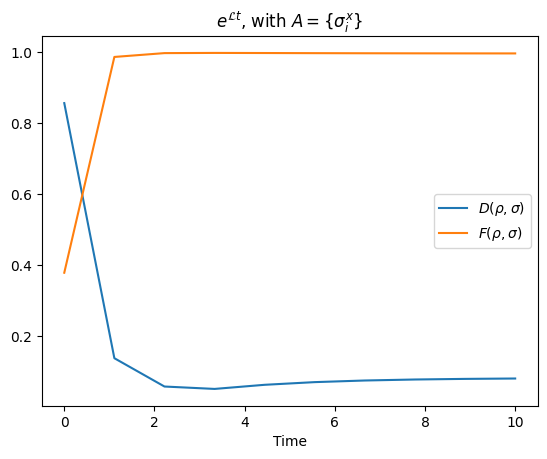

In [44]:
plt.figure() 
plt.title('$e^{\mathcal{L}t}$, with $A = \{\sigma_i^x\}$')
plt.plot(times, result_qt.expect[0]) 
plt.plot(times, result_qt.expect[1]) 
plt.xlabel('Time') 
plt.legend(("$D(\\rho, \sigma)$", "$F(\\rho, \sigma)$")) 
plt.show() 

### $\left[ \mathbb{I} + \mathcal{L}\delta + \mathcal{O}(\delta^2) \right] \times \lceil t_{mix} / \delta \rceil$

In [45]:
def alg_liouv_evolve(initial_dm: np.ndarray, time: float, delta: float, jump_ops: list[np.ndarray]) -> np.ndarray:
    """
    time evolution is between [0, time]
    `jump_ops`: non-OFT form
    """
    
    num_liouv_steps = int(np.ceil(time / delta))
    
    N = 2**num_energy_bits
    N_labels = np.arange(N / 2, dtype=int)
    N_labels_neg = np.arange(- N / 2, 0, dtype=int)
    N_labels = np.concatenate((N_labels, N_labels_neg))
    
    boltzmann = lambda beta, energy: np.min([1, np.exp(-beta * energy)])
    
    evolved_dms = []
    evolved_dm = deepcopy(initial_dm)
    #* Exact
    for liouv_step in range(num_liouv_steps): #? Normalize?
        print(f'Liouv step {liouv_step}')
        
        rand_jump_index = np.random.randint(0, len(jump_ops))
        jump_op = jump_ops[rand_jump_index]
        print(f'Jump on site {rand_jump_index}')
        
        previous_dm = deepcopy(evolved_dm) / np.trace(evolved_dm)
        for phase in N_labels:
            energy = 2 * np.pi * phase / N
            oft_op = oft(jump_op, phase, N, sigma, hamiltonian=hamiltonian.qt.full())
            evolved_dm += delta * boltzmann(beta, energy)*(-0.5 * oft_op.conj().T @ oft_op @ previous_dm
                                            -0.5 * previous_dm @ oft_op.conj().T @ oft_op
                                            + oft_op @ previous_dm @ oft_op.conj().T)

        evolved_dms.append(evolved_dm / np.trace(evolved_dm))
        
    return evolved_dms

alg_evolved_dms = alg_liouv_evolve(initial_dm, mix_time*3, 1.0, jump_ops=x_jump_ops)


Liouv step 0
Jump on site 1
Liouv step 1
Jump on site 1
Liouv step 2
Jump on site 0
Liouv step 3
Jump on site 2
Liouv step 4
Jump on site 0
Liouv step 5
Jump on site 2
Liouv step 6
Jump on site 0
Liouv step 7
Jump on site 0
Liouv step 8
Jump on site 0
Liouv step 9
Jump on site 1
Liouv step 10
Jump on site 1
Liouv step 11
Jump on site 2
Liouv step 12
Jump on site 0
Liouv step 13
Jump on site 1
Liouv step 14
Jump on site 2
Liouv step 15
Jump on site 2
Liouv step 16
Jump on site 2
Liouv step 17
Jump on site 2
Liouv step 18
Jump on site 2
Liouv step 19
Jump on site 2
Liouv step 20
Jump on site 2
Liouv step 21
Jump on site 2
Liouv step 22
Jump on site 2
Liouv step 23
Jump on site 0
Liouv step 24
Jump on site 0
Liouv step 25
Jump on site 2
Liouv step 26
Jump on site 2
Liouv step 27
Jump on site 1
Liouv step 28
Jump on site 0
Liouv step 29
Jump on site 0


In [46]:
# exact_state_at_t = lambda t: result_qt.states[np.argmin(np.abs(times - t))]
#? Why can the fidelity be over 1 in larger delta cases? Is it because it somehow deviates after a while from a CPTP map
#? And for that Fidelity becomes inappropriate, even if we normalize the states?

exact_state = result_qt.states[-1] / np.trace(result_qt.states[-1])

trdist_alg_exact = qt.tracedist(qt.Qobj(alg_evolved_dms[-1]), exact_state)
fid_alg_exact = qt.fidelity(qt.Qobj(alg_evolved_dms[-1]), exact_state)
print(f'Trace distance between exact and alg is {trdist_alg_exact}')
print(f'Fidelity between exact and alg is {fid_alg_exact}')

Trace distance between exact and alg is 0.08120754484553538
Fidelity between exact and alg is 0.9962293853145081


<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\d'
/var/folders/pg/6vn02n251m14stcv7vg03pjr0000gn/T/ipykernel_57383/3881565001.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$\mathbb{I} + \mathcal{L}\delta + \mathcal{O}(\delta^2)$ with $A\in\{\sigma_i^x\}$')
/var/folders/pg/6vn02n251m14stcv7vg03pjr0000gn/T/ipykernel_57383/3881565001.py:10: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(("$D(\\rho, \sigma)$", "$F(\\rho, \sigma)$"))
/var/folders/pg/6vn02n251m14stcv7vg03pjr0000gn/T/ipykernel_57383/3881565001.py:10: SyntaxWarning: invalid escape sequence '\s'
  plt.legend(("$D(\\rho, \sigma)$", "$F(\\rho, \sigma)$")

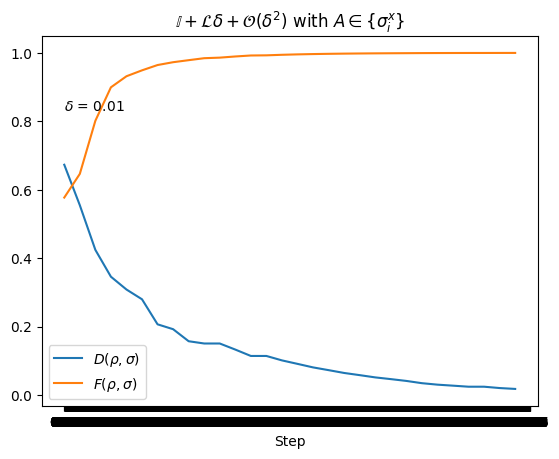

In [47]:
liouv_times = np.linspace(0.0, mix_time*3, len(alg_evolved_dms))
fid_alg_with_gibbs = [qt.fidelity(qt.Qobj(dm), qt.Qobj(gibbs)) for dm in alg_evolved_dms]
trdist_alg_with_gibbs = [qt.tracedist(qt.Qobj(dm), qt.Qobj(gibbs)) for dm in alg_evolved_dms]
plt.figure() 
plt.title('$\mathbb{I} + \mathcal{L}\delta + \mathcal{O}(\delta^2)$ with $A\in\{\sigma_i^x\}$')
plt.plot(liouv_times, trdist_alg_with_gibbs) 
plt.plot(liouv_times, fid_alg_with_gibbs) 
plt.xlabel('Step')
plt.xticks(np.arange(0, mix_time*3 + 1, delta))
plt.legend(("$D(\\rho, \sigma)$", "$F(\\rho, \sigma)$"))
plt.annotate(f'$\delta$ = {delta}', xy=(0, 0.83))
plt.show() 

### Spectral gap / mixing time

In [48]:
all_oft_jump_ops = []
for i in range(len(x_jump_ops)):
    jump_op = x_jump_ops[i]
    for phase in N_labels:
        energy = 2 * np.pi * phase / 2**num_energy_bits
        oft_op = oft(jump_op, phase, 2**num_energy_bits, sigma, hamiltonian=hamiltonian.qt.full())
        all_oft_jump_ops.append(qt.Qobj(oft_op))

no_H = qt.qeye(2**num_qubits)
liouvillian = qt.liouvillian(no_H, c_ops=all_oft_jump_ops)

In [49]:
spectrum = liouvillian.eigenenergies()
spectral_gap = spectrum[-1] - spectrum[-2]
print(f'Spectral gap {spectral_gap}')
smallest_gibbs_ev = qt.Qobj(gibbs).eigenenergies()[0]
print(f'Smallest eigenvalue of Gibbs state {smallest_gibbs_ev}')

desired_trdist = 0.3
mixing_time_bound = (np.log(np.sqrt(1 / smallest_gibbs_ev)) -np.log(desired_trdist)) / spectral_gap
print(f'Mixing time bound {mixing_time_bound}')

Spectral gap 0.25616789909083354
Smallest eigenvalue of Gibbs state 0.09805527488367287
Mixing time bound 9.232557153591214


### Mixing time with log-Sobolev